## 0. Basic

### Display the some first `image_file_names` & `file_name.csv`

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## print out the names of the first 5 image_files (total = 10 images for train_imgaes & train_label_masks) with the train, test, submission.csv files & 5 file.hdf5
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:3]:
        print(os.path.join(dirname, filename))

/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/eac2bfcf6b1dd7733ab9e2f31452e5bd.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/6ccb8529cc90ff30751eff7a1d055b6e.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/5f204e4117e261c6bfb06626e5bb2410.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/3e16a4a0816d8380163af60dfc884195_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/3639415568d06af82c3cfcfeeae5d9b6_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/466a84e8d13813e7aabfe440f437d990_mask.tiff
/kaggle/input/pytable-hdf/img_dtbase_3750.h5
/kaggle/input/pytable-hdf/img_dtbase_10250.h5
/kaggle/input/pytable-hdf/img_dtbase_5000.h5


## Basic libraries

### Loading & viewing dataset

In [2]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

# Location of the training images

BASE_PATH = '../input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [4]:
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [5]:
print("Shape of training data :", train.shape)
print("Mainly information of training data :", train.info())
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

Shape of training data : (10616, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 10616 entries, 0005f7aaab2800f6170c399693a96917 to ffe9bcababc858e04840669e788065a1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_provider  10616 non-null  object
 1   isup_grade     10616 non-null  int64 
 2   gleason_score  10616 non-null  object
dtypes: int64(1), object(2)
memory usage: 331.8+ KB
Mainly information of training data : None
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


### 2. Create the `mutual_id_image` 

In the previous sesion, we have show that it concided to the mask_dir

In [132]:
id_dir = [name.replace('_mask.tiff', '') for name in os.listdir(mask_dir)]
id_dir[:5]

['3e16a4a0816d8380163af60dfc884195',
 '3639415568d06af82c3cfcfeeae5d9b6',
 '466a84e8d13813e7aabfe440f437d990',
 '5c869a5a8bd2bd340fe13b188be333c1',
 'db6d351561cec54486ab371f4faf3b40']

**Viewing insight dataset**

In [7]:
test.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [8]:
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


### 3. Create a function get_tiles

First of all, we must ignore the white image

id_image verify : 3790f55cad63053e956fb73027179707
Oops! this image is whole white
CPU times: user 104 ms, sys: 5.52 ms, total: 110 ms
Wall time: 94.9 ms


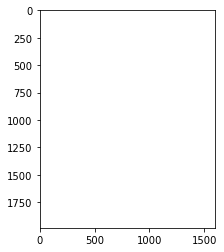

In [125]:
def verify_whole_white_image(img_id):
    print("id_image verify : %s"%(img_id))
    full_mask = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[2]
    if np.all(full_mask == 255) == False:
        print("not white")
    else:
        print("Oops! this image is whole white")
    plt.imshow(full_mask)
%time verify_whole_white_image(id_dir[458])

id_image verify : aa6fa0228a86251c04d6a74b7bcf1b12
not white
CPU times: user 140 ms, sys: 4.25 ms, total: 144 ms
Wall time: 121 ms


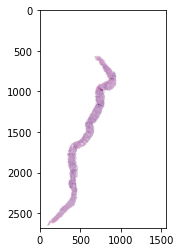

In [126]:
%time verify_whole_white_image(id_dir[457])

Now, we will choose the `non-white-image` from the `id_dir`

In [127]:
def create_not_empty_image(img_list):
    """
            This function help you advoid the white image when select the img_id from the id_dir
    """
    ls = []
    for img_id in id_dir:
        full_mask = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[2]
        if np.all(full_mask == 255) == False:
            ls.append(img_id)
    return ls
%time img_id_mutual_name = create_not_empty_image(id_dir)
img_id_mutual_name[:5], len(img_id_mutual_name)

CPU times: user 4min 17s, sys: 34.5 s, total: 4min 51s
Wall time: 5min 52s


(['3e16a4a0816d8380163af60dfc884195',
  '3639415568d06af82c3cfcfeeae5d9b6',
  '466a84e8d13813e7aabfe440f437d990',
  '5c869a5a8bd2bd340fe13b188be333c1',
  'db6d351561cec54486ab371f4faf3b40'],
 10515)

Hence, that is only the `img_id = "3790f55cad63053e956fb73027179707" ` is `whole_white_image`

So, from now, to optimize time, we will remove the `3790f55cad63053e956fb73027179707.tiff` only

**Target.** generate the list of list contains `string (image_id)` and `list of integers of image_coordinate`

    output = [[img_id, img_coordinate_1], ..., [img_id, ..., img_coordinate_36]]

In [128]:
def split_get_coordinate(img_id, crit = 0.0005, size=512, n_tiles=36):    
    """
    ==================================================================================================
    Input:  img_id (str): image_id from the train dataset, such as '004dd32d9cd167d9cc31c13b704498af'  
            crit (float) in (0, 1): the proportion of the dark_region over whole image (size 256 x 256)
            size (int) : image size
            n_tiles : number of tiles
    return: 
            list of (img_id, x_start, x_end, y_start, y_end) images size 512x512    
            ==========================================================================================
    writen by Nhan
    ==================================================================================================
    """
    img = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[0]
    tile_size = 512
    h, w = img.shape[: 2]
    nc = int(w / 512)
    nr = int(h / 512)
    img_ls = []
    coord_ls = []
    S_img_tile = 512*512*3
    
    for i in range(nr):
        for j in range(nc):
            x_start, y_start = int(i*512), int(j*512)
            image_dt = img[ x_start : x_start + 512, y_start : y_start + 512 , :]
            if (image_dt.min() < 185):
                count = len(image_dt[image_dt <= 121])
                if count/(S_img_tile) >= crit:
                    image_dt = cv2.resize(image_dt, (size, size), interpolation = cv2.INTER_AREA)
                    img_ls.append(image_dt)
                    coord_ls.append([img_id, x_start, x_start + 512, y_start, y_start + 512 ])
                    del image_dt, x_start, y_start

    ## choose n_tiles image has a best-view_range 
    img3_dt_ = np.array(img_ls)
    idxs_dt_ = np.argsort(img3_dt_.reshape(img3_dt_.shape[0],-1).sum(-1))[:n_tiles]
    
    del img3_dt_
    ## attach
    final_coordinate_range = []; final_tiles_image = []
    for final_index in idxs_dt_:
        final_coordinate_range.append(coord_ls[final_index]) 
    del img_ls, coord_ls
    return final_coordinate_range
    
%time u = split_get_coordinate(img_id_mutual_name[458])
u[:4]

CPU times: user 516 ms, sys: 66.3 ms, total: 582 ms
Wall time: 426 ms


[['df29712be2badfd7ae0ef37d30759042', 4608, 5120, 512, 1024],
 ['df29712be2badfd7ae0ef37d30759042', 5632, 6144, 512, 1024],
 ['df29712be2badfd7ae0ef37d30759042', 5120, 5632, 512, 1024],
 ['df29712be2badfd7ae0ef37d30759042', 4096, 4608, 512, 1024]]

### 4. Quick example for using `get_tiles`

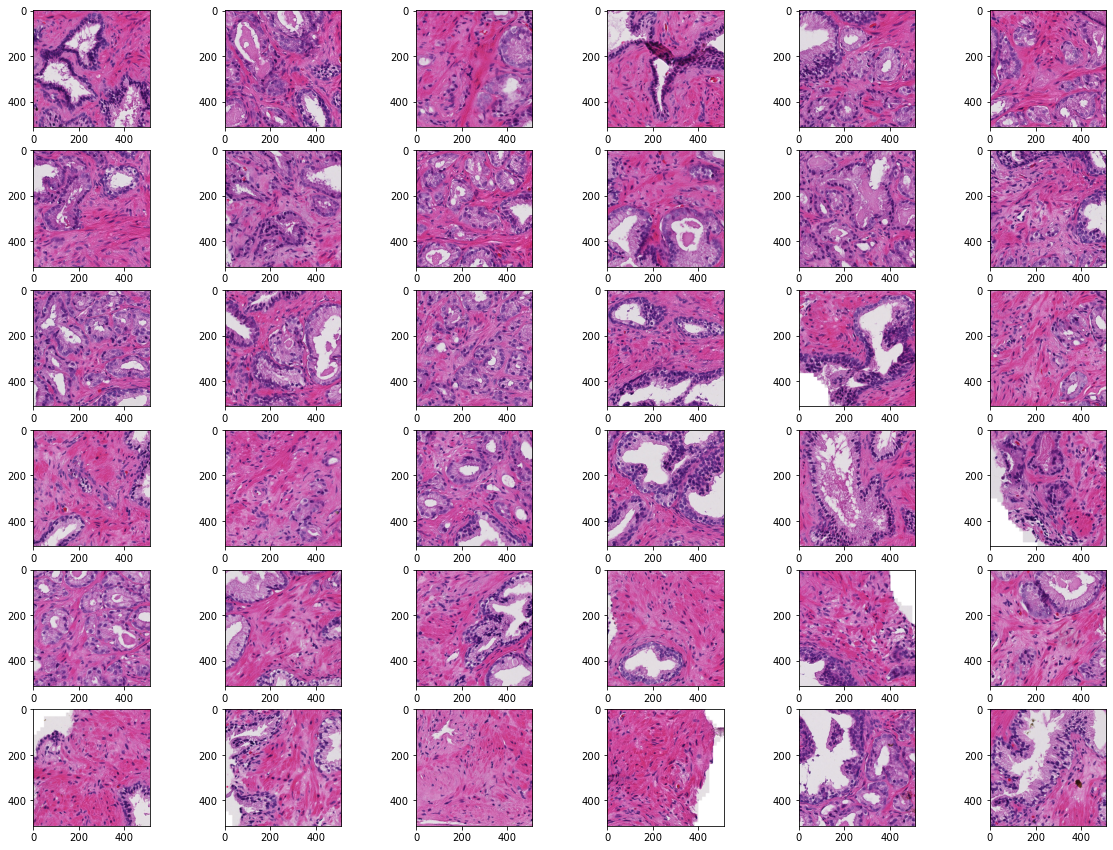

In [36]:
del u
ID = img_id_mutual_name[999]
def display_dt_img(ID):
    """
    something
    """
    full_img = skimage.io.MultiImage(os.path.join(data_dir, f'{ID}.tiff'))[0]
    u = split_get_coordinate(ID)
    plt.figure(figsize = (15, 15))
    for k in range(len(u)):
        x_start, x_end, y_start, y_end = u[k][1:]
        plt.subplot(6, 6, k + 1)
        plt.imshow(full_img[x_start : x_end, y_start : y_end, :])
    plt.show()
    
%time display_dt_img(ID)

image_showing : Full Mask & full data

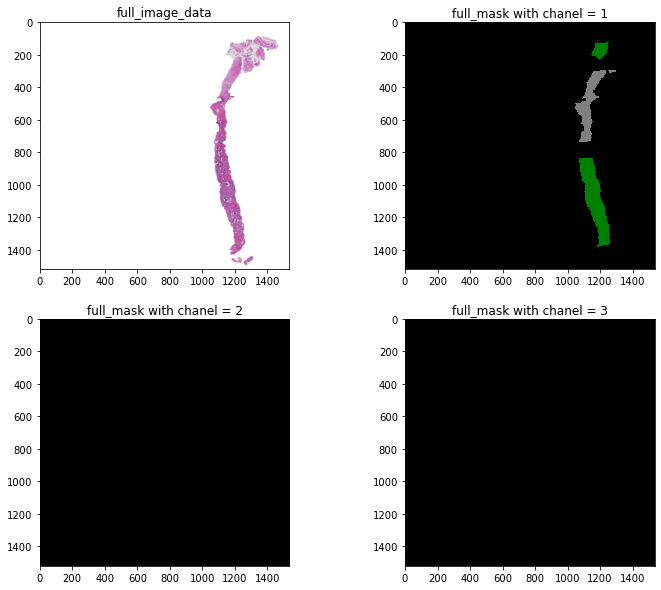

In [134]:
ID = img_id_mutual_name[999]
full_mask = skimage.io.MultiImage(os.path.join(mask_dir, f'{ID}_mask.tiff'))[2]
full_img = skimage.io.MultiImage(os.path.join(data_dir, f'{ID}.tiff'))[2]
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

plt.figure(figsize = (12, 10))
plt.subplot(221), plt.imshow(full_img), plt.title('full_image_data')
for k in range(1,4):
    plt.subplot(2,2, k+1), plt.title('full_mask with chanel = %s'%(k))
    plt.imshow(full_mask[:,:,k-1], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
plt.show()
del full_mask, full_img

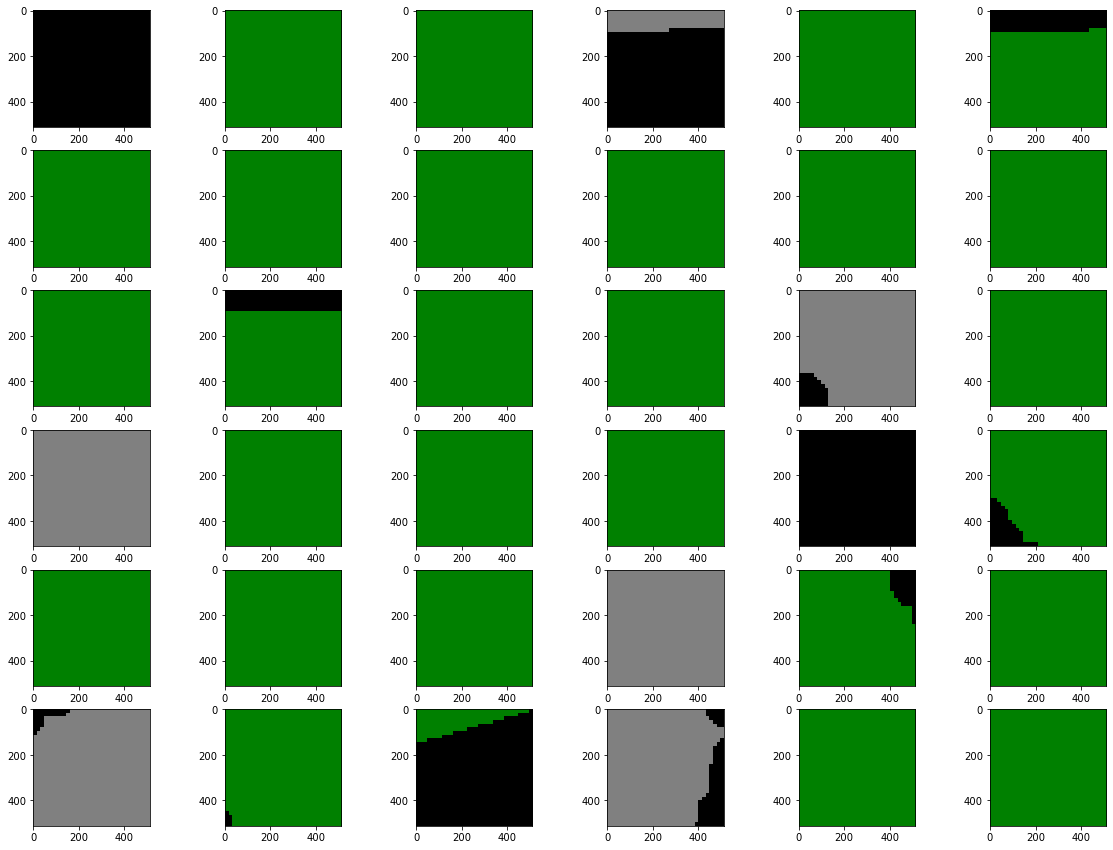

CPU times: user 12.9 s, sys: 3.03 s, total: 16 s
Wall time: 12 s


In [59]:
def display_mask_img(ID):
    """
    """
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    full_img = skimage.io.MultiImage(os.path.join(mask_dir, f'{ID}_mask.tiff'))[0]
    u = split_get_coordinate(ID)
    plt.figure(figsize = (20, 15))
    for k in range(len(u)):
        x_start, x_end, y_start, y_end = u[k][1:]
        plt.subplot(6, 6, k + 1)
        plt.imshow(full_img[x_start : x_end, y_start : y_end, :][:,:,0], 
                   cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.show()

%time display_mask_img(ID)

### 5. Create dictionary of list to attach to `h5.file`

In [129]:
import time
import deepdish as dd
def attach_dict(n, show = True):  
    """
    Input arguments:
        - n (int from 1 to 9): an integer decide our tasks (for instance Nhan : {1,2,3}; Khoa : {4, 5, 6}; Han: {7, 8 ,9})
        - show (bool): display whether the attaching_process or not
    return output: 
         data of 36 tile_coordinate & corresponding id_img of 1168 images
    """
    img_coord = []
    bool_vrs = []
    img_id_mutual_names = []  ## we will replace later
    img_idx_mutual_names = img_id_mutual_name[80*(n-1) : 80*n]
    num_epchs = int(80 // 16)
    print("=======================/ Attachement Start \=======================")
    print("=======| attachement-speed predicted : 4-5(seconds/img_id) |=======")
    for epch in range(num_epchs):
        t0 = time.time()
        for img_id in img_idx_mutual_names[ int(epch*16): int((epch+1)*16)]:
            u = split_get_coordinate(img_id)
            if len(u) == 36:
                img_coord.append(u)
            del u
        if show == 1:
            print('Attached img_id %03d - %03d done, \t in %s second!'%(epch*16, (epch+1)*16 - 1, round(time.time() - t0, 2)))
        
    file_name = 'img_dtb' + str(n) + '.h5'
    dd.io.save(file_name, data = img_coord, compression=('blosc', 9))
    print("Well done ! We have completed this process!")
    del img_coord
    
attach_dict(n = 1)

=======================/ Attachement Start \=======================
=======| attachement-speed predicted : 4-5(seconds/img_id) |=======
Attached img_id 000 - 015 done, 	 in 66.53 second!
Attached img_id 016 - 031 done, 	 in 48.6 second!
Attached img_id 032 - 047 done, 	 in 71.73 second!
Attached img_id 048 - 063 done, 	 in 96.9 second!
Attached img_id 064 - 079 done, 	 in 89.7 second!
Well done ! We have completed this process!


In [11]:
from IPython.display import FileLink
FileLink('img_dtb1.h5')

/kaggle/working/img_dtb1.h5

**`Using the first variable in the final_result`**

**`Using the second variables to load the spling_images`**

In [12]:
import tables
import h5py
import deepdish as dd
#img_id_mutual_name[:10]

In [130]:
from sys import getsizeof
import deepdish as dd
#%time a = dd.io.load('img_dtb_04000.h5')
#getsizeof(a)

In [14]:
21660/1024

21.15234375

To find a link

In [131]:
X = {'a': [1, 2, 3, 4, 4], 'b' : [1, 2, 4]}
#dd.io.save('draft.h5', data = X)

import os
from IPython.display import FileLink
FileLink('img_dtb_06000.h5')

/kaggle/working/img_dtb_06000.h5